In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import os

# Load data

## Define districts we're interested in

In [3]:
CARE_ADMIN1 = ["Masvingo", "Manicaland"] # Buhera, Mutare, Zaka, Chivi
CNFA_ADMIN1 = ["Matabeleland North"] # "Binga", "Hwagne", "Lupane", "Nkayi", "Tsholotsho"

CARE_ADMIN2 = ["Buhera", 'Mutare Rural', "Zaka", "Chivi"]
CNFA_ADMIN2 = ["Binga", 'Hwange Rural', "Lupane", "Nkayi", "Tsholotsho"]

## Simulated data

In [4]:
sim_df = pd.read_csv("data/validation_runs.csv")
sim_df["year"] += 1 # Harvest is counted towards harvest year (next year after planting)
sim_df = sim_df.set_index(["admin_2", "year"])
sim_df = sim_df.loc[sim_df.type == "rainfed"]
sim_df = sim_df.loc[(sim_df.MAT > 0) & (sim_df.FLO > 0)] # Drop crop failures
sim_df = sim_df.loc[CARE_ADMIN2 + CNFA_ADMIN2]

## Observed data

In [5]:
obs_df = pd.read_csv("data/zimbabwe_main_maize.csv")
obs_df = obs_df.set_index(["admin_2", "year"])
obs_df["sim_value"] = sim_df.groupby(sim_df.index).HARWT.mean()
obs_df["obs_value"] = obs_df.value*1000
obs_df = obs_df.dropna().sort_index()

# Explore simulated results

## Average of all simulations

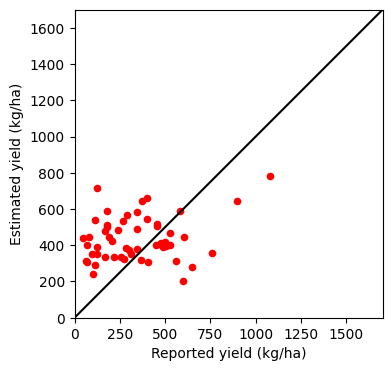

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

obs_df.plot.scatter(
    x="obs_value", y="sim_value", ax=ax,
    color='r'
)

ax.set_aspect('equal')
ax.set_xlabel("Reported yield (kg/ha)")
ax.set_ylabel("Estimated yield (kg/ha)")
ax.axline((0, 0), slope=1, color='k')
ax.set_xlim(0, 1700)
ax.set_ylim(0, 1700);

''

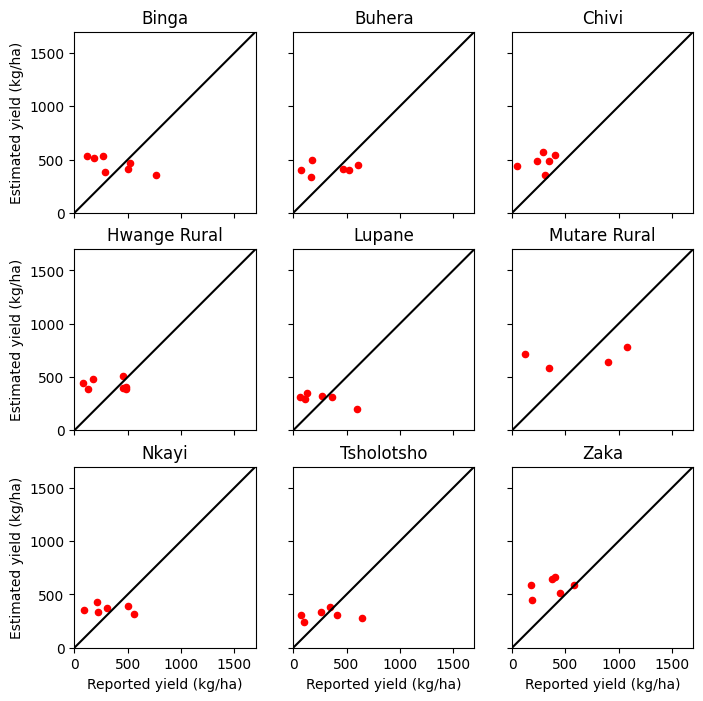

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

for n, admin_2 in enumerate(obs_df.index.get_level_values(0).unique()):
    ax = axes[n]
    obs_df.loc[admin_2].plot.scatter(
        x="obs_value", y="sim_value", ax=ax,
        color='r'
    )
    
    ax.set_aspect('equal')
    ax.set_xlabel("Reported yield (kg/ha)")
    ax.set_ylabel("Estimated yield (kg/ha)")
    ax.axline((0, 0), slope=1, color='k')
    ax.set_xlim(0, 1700)
    ax.set_ylim(0, 1700)
    ax.set_title(admin_2)
;

## Bias correction

Some districts (Chivi, Hwange, Zaka) seem to have a positive BIAS. The model prediction is bias corrected to have an unbiased model, and a better known error. 

In [14]:
log_bias = obs_df.groupby(level="admin_2").apply(
    lambda gb: (np.log(gb.sim_value) - np.log(gb.obs_value)).mean()
)
obs_df["sim_value_unbiased"] = np.exp(
    np.log(obs_df.sim_value) - obs_df.index.get_level_values(0).map(log_bias)
)

''

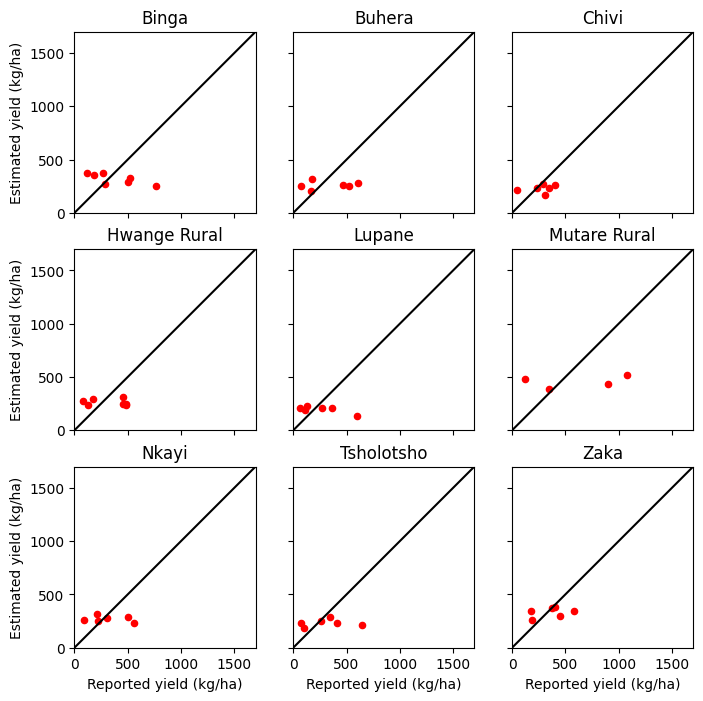

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

for n, admin_2 in enumerate(obs_df.index.get_level_values(0).unique()):
    ax = axes[n]
    obs_df.loc[admin_2].plot.scatter(
        x="obs_value", y="sim_value_unbiased", ax=ax,
        color='r'
    )
    
    ax.set_aspect('equal')
    ax.set_xlabel("Reported yield (kg/ha)")
    ax.set_ylabel("Estimated yield (kg/ha)")
    ax.axline((0, 0), slope=1, color='k')
    ax.set_xlim(0, 1700)
    ax.set_ylim(0, 1700)
    ax.set_title(admin_2)
;

# Final model error

In [38]:
model_error = obs_df.groupby(level="admin_2").apply(
    lambda gb: pd.Series({
        "RMSE": np.sqrt((gb.sim_value - gb.obs_value)**2).mean(),
        "RMSE_unbiased": np.sqrt((gb.sim_value_unbiased - gb.obs_value)**2).mean(),
        "obs_mean": gb.obs_value.mean(),
        "obs_std": gb.obs_value.std(),
        # "r2_unbiased": 1 - ((gb.obs_value - gb.sim_value_unbiased)**2).sum()/((gb.obs_value - gb.obs_value.mean())**2).sum()
    })
)
model_error["log_bias"] = log_bias
model_error

,RMSE,RMSE_unbiased,obs_mean,obs_std,log_bias
admin_2,,,,,
Binga,238.861732,211.141091,376.696714,228.185373,0.360460
Buhera,193.949006,195.389606,335.866750,224.279094,0.462264
Chivi,208.148814,95.649637,272.071186,122.395308,0.730308
Hwange Rural,172.200081,179.652034,322.202446,185.521083,0.492597
Lupane,193.148627,168.804897,256.891729,203.293080,0.425324
Mutare Rural,345.793899,356.569657,611.358553,451.548875,0.406183
Nkayi,170.319802,145.275781,314.544277,182.419357,0.309550
Tsholotsho,160.302536,152.233751,303.614092,214.057651,0.274519
Zaka,212.075027,107.405693,362.508306,155.085637,0.539941


In [39]:
model_error.to_csv("data/model_error.csv")